In [ ]:
import tensorflow as tf
import numpy as np
import random, os, glob, time
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
plt.style.use('dark_background')
sns.set_style("dark")  # Use Seaborn's dark style

plt.rcParams.update({
    'figure.facecolor': '#222222',   # Dark figure background
    'axes.facecolor':   '#222222',     # Dark axes background
    'axes.edgecolor':   'white',       # White axes edges
    'axes.labelcolor':  'white',       # White axis labels
    'xtick.color':      'white',       # White x-tick labels
    'ytick.color':      'white',       # White y-tick labels
    'grid.color':       'white',       # White grid lines (with reduced alpha in plots)
    'text.color':       'white',       # White text
    'legend.frameon':   False,         # No legend frame
    'font.size':        12,
    'axes.labelsize':   14,
    'axes.titlesize':   16,
    'legend.fontsize':  12,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12
})


In [5]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Data and image parameters
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 224, 224, 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
TRAIN_DIR = 'data/chest_xray/chest_xray/train'
TEST_DIR  = 'data/chest_xray/chest_xray/test'
# Assume training folder has one subfolder per class (e.g., NORMAL, PNEUMONIA)
NUM_CLASSES = len([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
# For episodic (few–shot) training:
K_SHOT  = 8  # number of support images per class per episode
Q_QUERY = 8  # number of query images per class per episode

print(f"Found {NUM_CLASSES} classes in training data.")

def load_data_by_class(data_dir):
    """
    Loads file paths for each class into a dictionary.
    """
    data = {}
    for cls in os.listdir(data_dir):
        full_dir = os.path.join(data_dir, cls)
        if os.path.isdir(full_dir):
            files = glob.glob(os.path.join(full_dir, '*'))
            data[cls] = files
    return data


test_data  = load_data_by_class(TEST_DIR)

Found 2 classes in training data.


In [6]:
def generate_episode(data, num_classes=NUM_CLASSES, k_shot=K_SHOT, q_query=Q_QUERY):
    """
    Generate one episode:
      - Randomly sample 'num_classes' from available classes.
      - For each, randomly sample k_shot support images and q_query query images.
    Returns:
      support_images, support_labels, query_images, query_labels, selected_classes.
    """
    support_images, support_labels = [], []
    query_images, query_labels = [], []
    selected_classes = random.sample(list(data.keys()), num_classes)
    for i, cls in enumerate(selected_classes):
        images = random.sample(data[cls], k_shot + q_query)
        support_files = images[:k_shot]
        query_files   = images[k_shot:]
        for img_path in support_files:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = tf.keras.preprocessing.image.img_to_array(img)
            support_images.append(img)
            label = np.zeros(num_classes)
            label[i] = 1
            support_labels.append(label)
        for img_path in query_files:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = tf.keras.preprocessing.image.img_to_array(img)
            query_images.append(img)
            label = np.zeros(num_classes)
            label[i] = 1
            query_labels.append(label)
    # Normalize images:
    support_images = np.array(support_images) / 255.0
    query_images   = np.array(query_images)   / 255.0
    return (support_images, 
            np.array(support_labels, dtype=np.float32), 
            query_images, 
            np.array(query_labels, dtype=np.float32),
            selected_classes)


In [ ]:
# Load the original model
original_model = load_model('models/original_model.h5')

# Load the prototypical backbone model
proto_backbone = load_model('models/proto_backbone.h5')

In [8]:
#############################
# Optimized Prototypical Network Functions
#############################

@tf.function
def prototypical_network_prediction_fast(embedding_model, prototypes, query_imgs):
    """
    Optimized prediction: Given precomputed prototypes and query images,
    compute query embeddings, distances, and return predictions.
    """
    query_embeddings = embedding_model(query_imgs)
    # Compute Euclidean distances between query embeddings and prototypes
    distances = tf.reduce_sum(tf.square(tf.expand_dims(query_embeddings, axis=1) - prototypes), axis=2)
    logits = -distances  # negative distances as logits
    predictions = tf.nn.softmax(logits, axis=1)
    return predictions

def compute_prototypes(embedding_model, support_imgs, support_lbls, num_classes=NUM_CLASSES):
    """
    Compute and return the prototypes for each class given support images and labels.
    """
    support_embeddings = embedding_model(support_imgs)
    prototypes = []
    for c in range(num_classes):
        # Create a mask for class c
        class_mask = tf.equal(tf.argmax(support_lbls, axis=1), c)
        class_embeddings = tf.boolean_mask(support_embeddings, class_mask)
        # Average to obtain the prototype for class c
        proto = tf.reduce_mean(class_embeddings, axis=0)
        prototypes.append(proto)
    prototypes = tf.stack(prototypes)
    return prototypes


In [9]:
# Generate an episode to serve as your fixed support set
s_imgs, s_lbls, _, _, selected_classes = generate_episode(test_data)

# Precompute and cache the prototypes using the prototypical network backbone
prototypes = compute_prototypes(proto_backbone, s_imgs, s_lbls, num_classes=NUM_CLASSES)


In [ ]:


# ---------------------------
# Evaluation of the Optimized Prototypical Network
# ---------------------------
proto_episodes = 50
total_correct = 0
total_samples = 0
proto_avg_times_per_image = []  # Store average time per image for each episode
episode_accuracies = []

# For aggregating predictions across episodes:
all_y_true_fast = []
all_y_pred_fast = []

for ep in range(proto_episodes):
    # Generate an episode: support and query sets come from the same episode.
    s_imgs, s_lbls, q_imgs, q_lbls, selected_classes = generate_episode(test_data)
    
    # Compute prototypes for the current episode's support set.
    prototypes = compute_prototypes(proto_backbone, s_imgs, s_lbls, num_classes=NUM_CLASSES)
    
    # Time only the inference step on the query images using the optimized prediction function.
    t0 = time.time()
    proto_preds_fast = prototypical_network_prediction_fast(proto_backbone, prototypes, q_imgs)
    inference_time_ep = time.time() - t0
    num_query_images = q_imgs.shape[0]
    
    # Skip if no query images (just in case)
    if num_query_images == 0:
        print(f"Episode {ep} has no query images; skipping.")
        continue
    
    avg_time_ep = inference_time_ep / num_query_images
    proto_avg_times_per_image.append(avg_time_ep)
    
    # Compute per-episode accuracy.
    pred_classes_fast = tf.argmax(proto_preds_fast, axis=1).numpy()
    true_classes = tf.argmax(q_lbls, axis=1).numpy()
    correct = np.sum(pred_classes_fast == true_classes)
    total_correct += correct
    total_samples += num_query_images
    episode_accuracies.append(correct / num_query_images)
    
    # Aggregate predictions for overall metrics.
    all_y_pred_fast.extend(pred_classes_fast.tolist())
    all_y_true_fast.extend(true_classes.tolist())

if total_samples > 0:
    proto_accuracy = total_correct / total_samples
else:
    proto_accuracy = 0

avg_proto_time_per_image = np.mean(proto_avg_times_per_image) if proto_avg_times_per_image else 0

print("\nPer-Episode Optimized Prototypical Network Evaluation:")
print(f"Average Accuracy: {proto_accuracy:.4f}")
print(f"Average Inference Time per Query Image: {avg_proto_time_per_image:.6f} seconds")

# ---------------------------
# Compute and Display the Confusion Matrix and Classification Report
# ---------------------------
cm_proto_fast = confusion_matrix(all_y_true_fast, all_y_pred_fast)
report_proto_fast = classification_report(all_y_true_fast, all_y_pred_fast, target_names=selected_classes)

print("\nAggregated Confusion Matrix (Optimized Prototypical Network):")
print(cm_proto_fast)
print("\nAggregated Classification Report (Optimized Prototypical Network):")
print(report_proto_fast)



Per-Episode Optimized Prototypical Network Evaluation:
Average Accuracy: 0.8525
Average Inference Time per Query Image: 0.121328 seconds

Aggregated Confusion Matrix (Optimized Prototypical Network):
[[343  57]
 [ 61 339]]

Aggregated Classification Report (Optimized Prototypical Network):
              precision    recall  f1-score   support

   PNEUMONIA       0.85      0.86      0.85       400
      NORMAL       0.86      0.85      0.85       400

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800



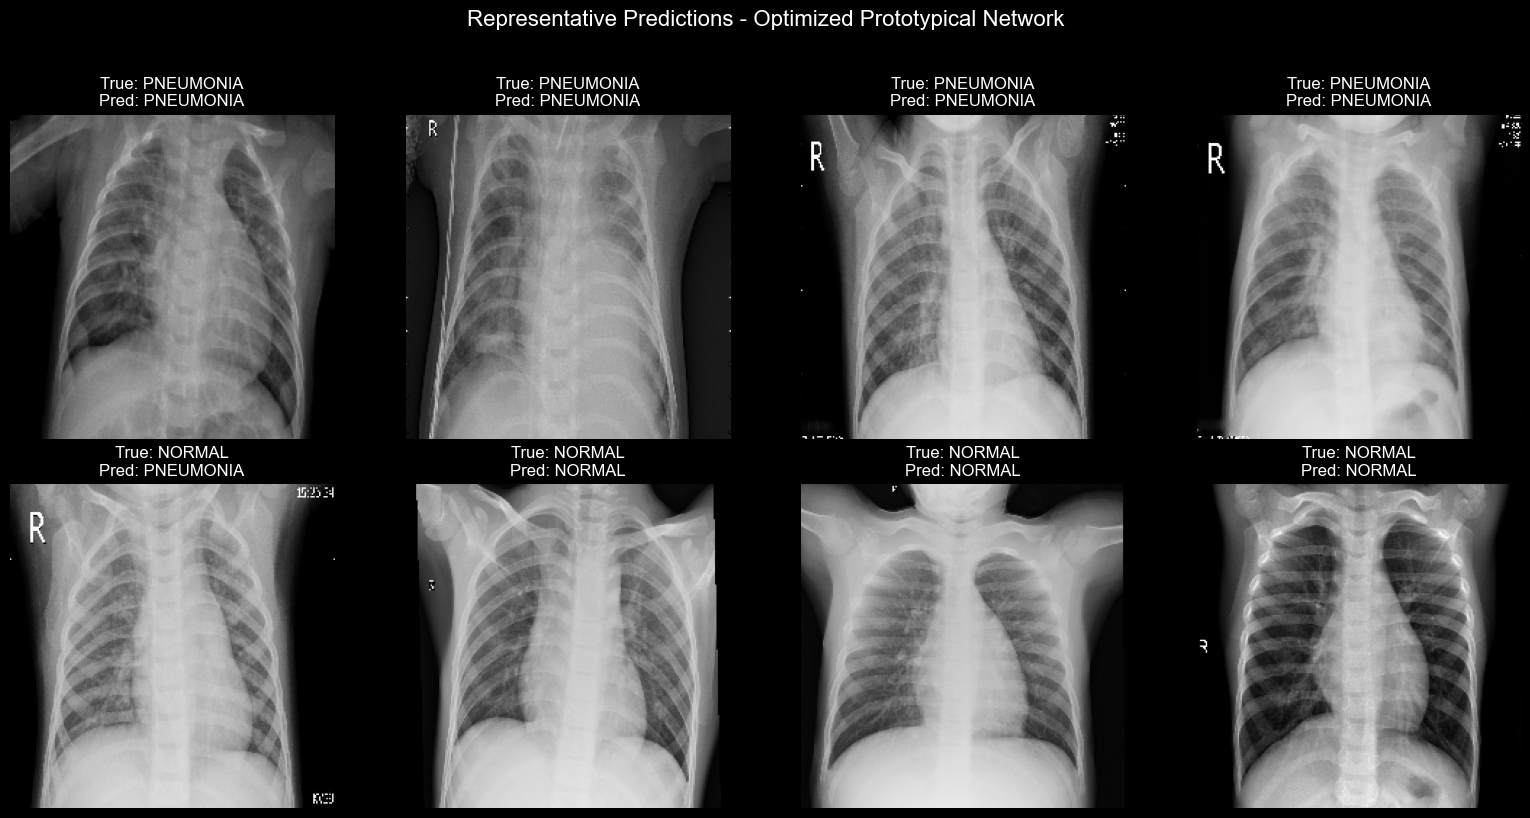

In [ ]:
def visualize_proto_model_optimized(proto_backbone, generate_episode, prototypical_network_prediction_fast,
                                    test_data, img_height=224, img_width=224, max_samples=4):
    """
    Generates one episode from the test data, computes prototypes from its support set,
    runs optimized inference on the query set, and visualizes exactly max_samples query images
    per class (e.g., NORMAL and PNEUMONIA) in a grid layout.
    
    Parameters:
      proto_backbone: The loaded prototypical network backbone model.
      generate_episode: Function that generates an episode.
      prototypical_network_prediction_fast: The optimized (tf.function-wrapped) prediction function.
      test_data: Dictionary containing test image paths by class.
      img_height, img_width: Image dimensions.
      max_samples: Number of query images per class to display.
    """
    plt.style.use('dark_background')
    
    # Generate an episode (support and query sets come from the same episode)
    s_imgs, s_lbls, q_imgs, q_lbls, selected_classes = generate_episode(test_data)
    
    # Compute prototypes for the current episode's support set
    prototypes = compute_prototypes(proto_backbone, s_imgs, s_lbls, num_classes=NUM_CLASSES)
    
    # Run optimized prediction on the query images using the fast (compiled) function
    proto_preds = prototypical_network_prediction_fast(proto_backbone, prototypes, q_imgs)
    pred_classes = tf.argmax(proto_preds, axis=1).numpy()
    true_classes = tf.argmax(q_lbls, axis=1).numpy()
    
    # For each class (assumed order in selected_classes), select exactly max_samples query images
    n_classes = len(selected_classes)  # e.g., 2 for "NORMAL" and "PNEUMONIA"
    selected_indices = []
    for class_idx in range(n_classes):
        indices = np.where(true_classes == class_idx)[0]
        # Ensure exactly max_samples per class are selected
        if len(indices) >= max_samples:
            selected_indices.extend(indices[:max_samples])
        else:
            selected_indices.extend(indices)
    
    # Reorder indices so that images from the same class are grouped together:
    class0_indices = [i for i in selected_indices if true_classes[i] == 0][:max_samples]
    class1_indices = [i for i in selected_indices if true_classes[i] == 1][:max_samples]
    ordered_indices = class0_indices + class1_indices  # total = 2 * max_samples
    
    # Setup a grid: one row per class and max_samples columns
    rows = n_classes
    cols = max_samples
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle("Representative Predictions - Optimized Prototypical Network", fontsize=16, y=1.02)
    
    for i, idx in enumerate(ordered_indices):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(q_imgs[idx])
        # Map numeric indices to class names using the selected_classes list:
        true_label = selected_classes[ true_classes[idx] ]
        pred_label = selected_classes[ pred_classes[idx] ]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_proto_model_optimized(proto_backbone, generate_episode, prototypical_network_prediction_fast,
                                test_data, img_height=224, img_width=224, max_samples=4)


In [12]:
# ---------------------------
# Evaluation of the Original Model
# ---------------------------
# Create a test data generator (note: images are rescaled)
test_datagen  = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=32, 
    class_mode='categorical',
    shuffle=False)  # shuffle=False to match predictions with true labels

# Measure inference time for the original model:
# --- Apples-to-Apples Inference Time for Original Model ---
# Get the total number of test images from the generator
num_test_images = test_generator.samples

# Run inference on the entire test set and measure total time
t0 = time.time()
orig_preds = original_model.predict(test_generator, steps=len(test_generator), verbose=1)
total_time = time.time() - t0

# Compute the average inference time per image
orig_avg_time_per_image = total_time / num_test_images
print(f"Original Model Total Inference Time: {total_time:.4f} seconds")
print(f"Original Model Average Inference Time per Image: {orig_avg_time_per_image:.6f} seconds")


# Evaluate model performance:
orig_eval = original_model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Original Model Evaluation Metrics:", orig_eval)

# Compute confusion matrix and classification report:
y_pred = np.argmax(orig_preds, axis=1)
y_true = test_generator.classes
cm_orig = confusion_matrix(y_true, y_pred)
report_orig = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))




print("Confusion Matrix (Original Model):")
print(cm_orig)
print("\nClassification Report (Original Model):")
print(report_orig)



Found 624 images belonging to 2 classes.


/Users/bobbytomlinson/Desktop/Coding/Personal/new/FewShotLearningForPneumonia/pneuFSLvenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step
Original Model Total Inference Time: 80.8485 seconds
Original Model Average Inference Time per Image: 0.129565 seconds
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.9098 - loss: 0.5198
Original Model Evaluation Metrics: [0.563895046710968, 0.8942307829856873]
Confusion Matrix (Original Model):
[[213  21]
 [ 45 345]]

Classification Report (Original Model):
              precision    recall  f1-score   support

      NORMAL       0.83      0.91      0.87       234
   PNEUMONIA       0.94      0.88      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.90      0.89       624
weighted avg       0.90      0.89      0.90       624



Found 624 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


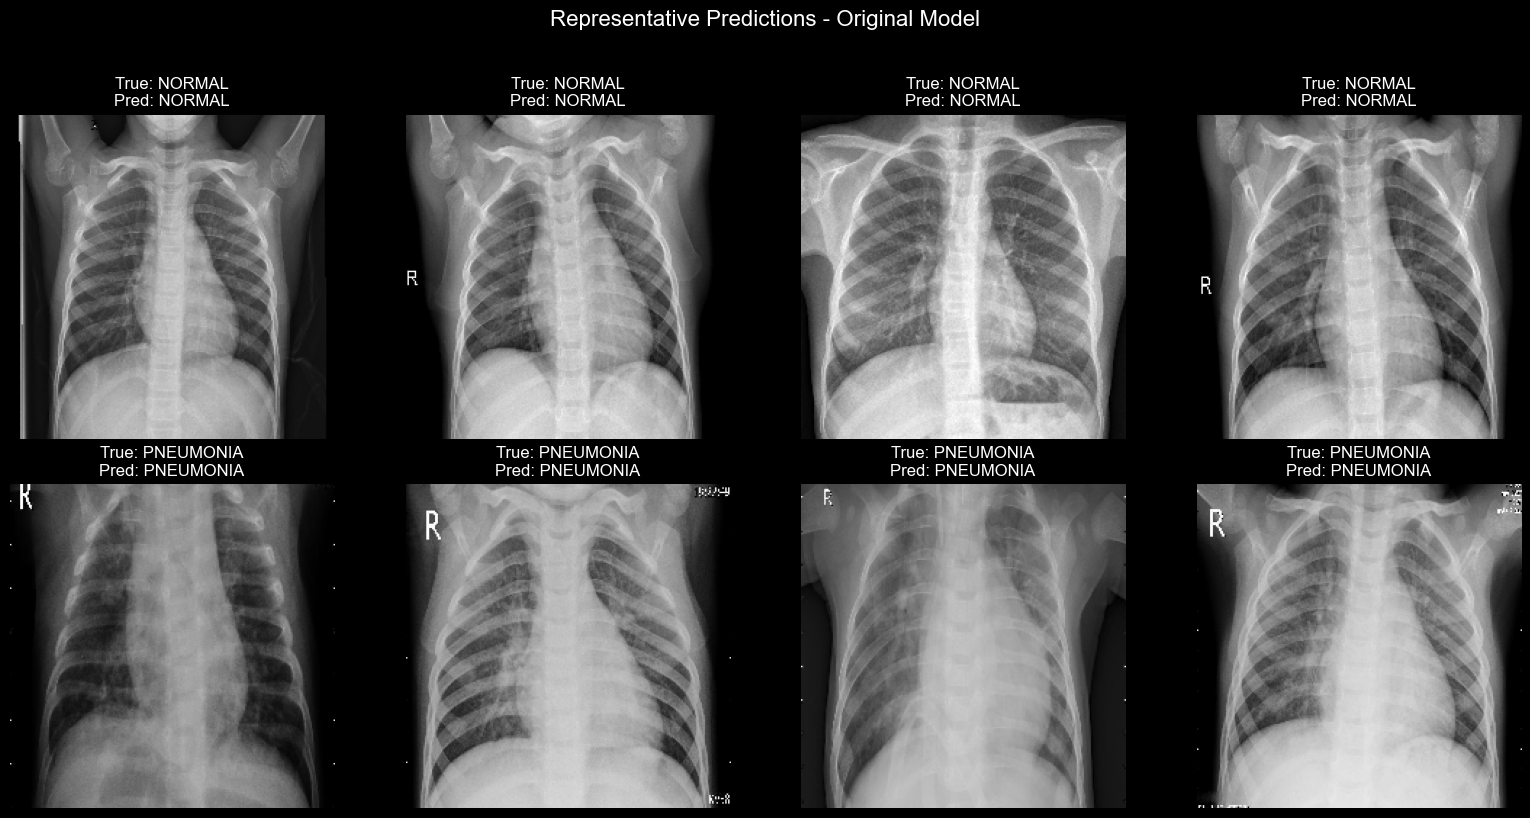

In [ ]:
def visualize_original_model_fixed(original_model, test_dir, img_height=224, img_width=224, max_samples=4):
    """
    Ensures that exactly max_samples examples from each of the two classes ("NORMAL" and "PNEUMONIA")
    are obtained from the test directory, runs inference on them, and visualizes the predictions.
    """
    plt.style.use('dark_background')
    
    # Use a larger batch size to increase chances of getting enough examples
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    
    required_classes = ['NORMAL', 'PNEUMONIA']
    # Prepare dictionaries to accumulate images and their true labels
    class_to_images = {cls: [] for cls in required_classes}
    class_to_true = {cls: [] for cls in required_classes}
    
    # Loop over batches until we have at least max_samples for each required class.
    while any(len(class_to_images[cls]) < max_samples for cls in required_classes):
        images, labels = next(test_generator)
        true_indices = np.argmax(labels, axis=1)
        # Mapping from index to class name using the generator's class_indices
        idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
        for i in range(len(images)):
            cls_name = idx_to_class[ true_indices[i] ]
            if cls_name in required_classes and len(class_to_images[cls_name]) < max_samples:
                class_to_images[cls_name].append(images[i])
                class_to_true[cls_name].append(true_indices[i])
    
    # Combine images from both classes in the desired order (e.g. NORMAL first, then PNEUMONIA)
    selected_images = []
    selected_true_labels = []
    for cls in required_classes:
        selected_images.extend(class_to_images[cls][:max_samples])
        selected_true_labels.extend(class_to_true[cls][:max_samples])
    
    selected_images = np.array(selected_images)
    
    # Run inference on the selected images
    preds = original_model.predict(selected_images)
    selected_pred_classes = np.argmax(preds, axis=1)
    
    # Re-create the mapping from index to class name
    idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
    
    # Set up the grid: two rows (one per class) and max_samples columns.
    rows = 2
    cols = max_samples
    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle("Representative Predictions - Original Model", fontsize=16, y=1.02)
    
    # Order the images so that first row is for "NORMAL" and second for "PNEUMONIA"
    # (Assuming test_generator.class_indices gives consistent ordering)
    for i in range(len(selected_images)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(selected_images[i])
        true_label_name = idx_to_class[selected_true_labels[i]]
        pred_label_name = idx_to_class[selected_pred_classes[i]]
        plt.title(f"True: {true_label_name}\nPred: {pred_label_name}", fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_original_model_fixed(original_model, TEST_DIR, img_height=224, img_width=224, max_samples=4)


In [14]:
import pandas as pd

# Build a summary dictionary using our updated variables:
# - orig_eval[1] is the overall test set accuracy for the original model.
# - optimized_accuracy is the accuracy from the optimized prototypical network inference.
# - orig_avg_time_per_image is the average inference time per image for the original model.
# - optimized_avg_time_per_image is the average inference time per query image for the optimized prototypical network.
metrics_summary = {
    "Method": ["Original Model", "Prototypical Network (Optimized)"],
    "Accuracy": [orig_eval[1], proto_accuracy],
    "Average Inference Time per Image (s)": [orig_avg_time_per_image, avg_proto_time_per_image]
}

df_metrics = pd.DataFrame(metrics_summary)
print("\n=== Updated Summary Metrics ===")
print(df_metrics)

df_metrics.to_csv("evaluation_summary_optimized.csv", index=False)
print("\nExported optimized evaluation metrics to evaluation_summary_optimized.csv")



=== Updated Summary Metrics ===
                             Method  Accuracy  \
0                    Original Model  0.894231   
1  Prototypical Network (Optimized)  0.852500   

   Average Inference Time per Image (s)  
0                              0.129565  
1                              0.121328  

Exported optimized evaluation metrics to evaluation_summary_optimized.csv


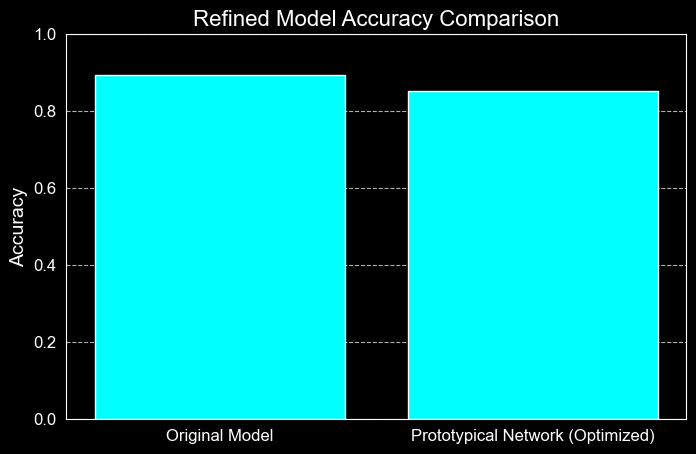

In [15]:
plt.figure(figsize=(8, 5))
plt.bar(df_metrics["Method"], df_metrics["Accuracy"], color='cyan')
plt.ylabel("Accuracy")
plt.title("Refined Model Accuracy Comparison")
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

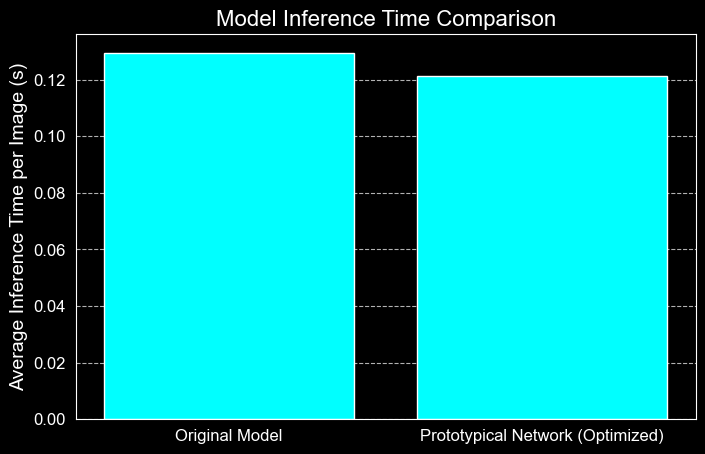

In [16]:
plt.figure(figsize=(8, 5))
plt.bar(metrics_summary["Method"], metrics_summary["Average Inference Time per Image (s)"], color='cyan')
plt.ylabel("Average Inference Time per Image (s)")
plt.title("Model Inference Time Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

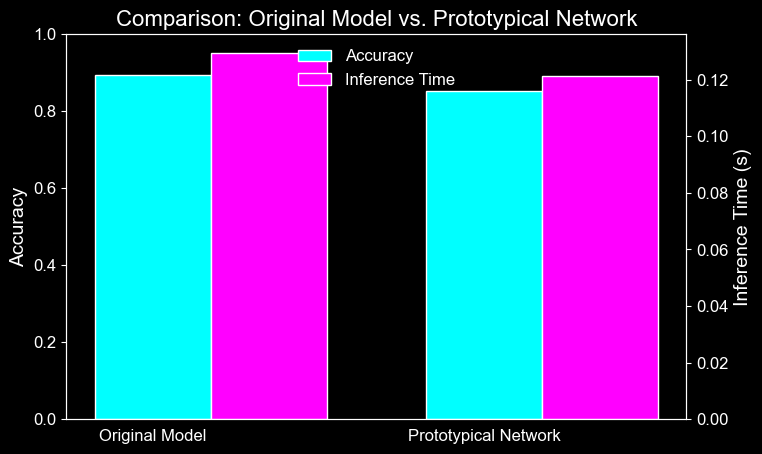

In [ ]:
# Create a DataFrame of your summary metrics (already exported to CSV in your notebook)
data = {
    "Method": ["Original Model", "Prototypical Network"],
    "Accuracy": [orig_eval[1], proto_accuracy],
    "Inference Time (s)": [orig_avg_time_per_image, avg_proto_time_per_image]
}
df_metrics = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(8, 5))
width = 0.35  # width of the bars
x = range(len(df_metrics))

# Plot Accuracy
ax1.bar(x, df_metrics["Accuracy"], width, label='Accuracy', color='cyan')
ax1.set_ylabel('Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(df_metrics["Method"])
ax1.set_ylim(0, 1)

# Create a twin axis for inference time
ax2 = ax1.twinx()
ax2.bar([p + width for p in x], df_metrics["Inference Time (s)"], width, label='Inference Time', color='magenta')
ax2.set_ylabel('Inference Time (s)')

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper center')

plt.title('Comparison: Original Model vs. Prototypical Network')
plt.show()


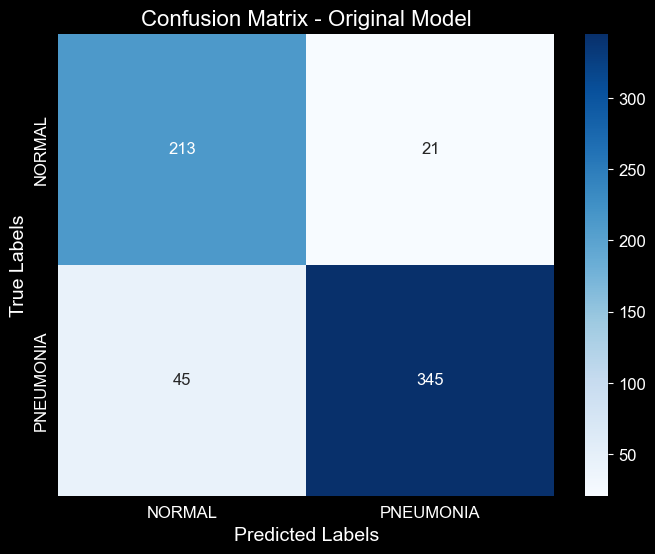

In [ ]:
# Create a heatmap of the confusion matrix for the Original Model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Original Model')
plt.show()


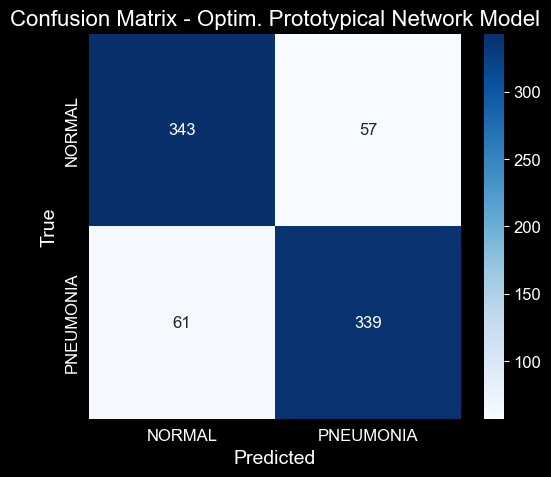

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_proto_fast, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Optim. Prototypical Network Model')
plt.show()


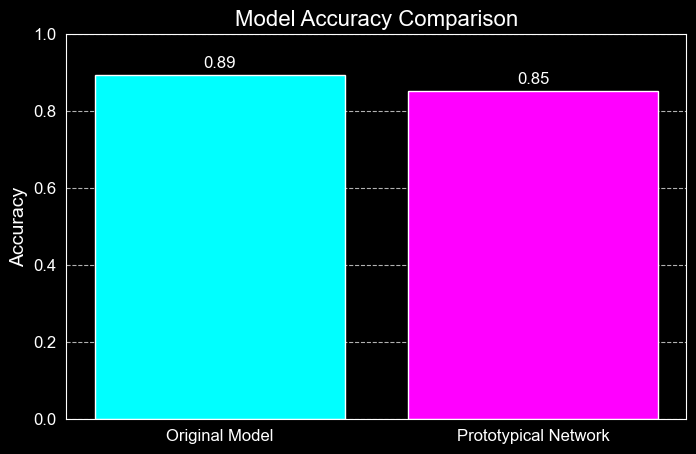

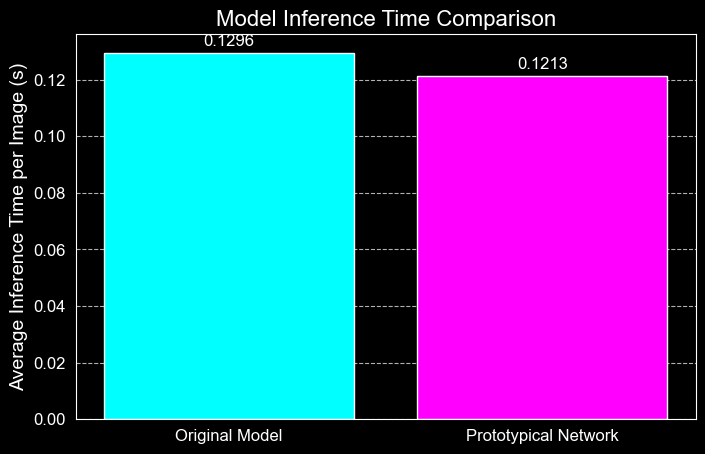

In [ ]:
# Define key metrics based on your computed variables:
#   - orig_eval[1] is the overall test set accuracy for the original model.
#   - proto_accuracy is the aggregated accuracy for the prototypical network.
#   - orig_avg_time_per_image is the average inference time per image for the original model.
#   - avg_proto_time_per_image is the average inference time per query image for the prototypical network.
methods = ['Original Model', 'Prototypical Network']
accuracy = [orig_eval[1], proto_accuracy]
inference_time = [orig_avg_time_per_image, avg_proto_time_per_image]

# Create a DataFrame to hold the metrics.
df_metrics = pd.DataFrame({
    'Method': methods,
    'Accuracy': accuracy,
    'Inference Time (s)': inference_time
})

# ----- Plot 1: Accuracy Comparison -----
plt.figure(figsize=(8, 5))
bars = plt.bar(df_metrics['Method'], df_metrics['Accuracy'], color=['cyan', 'magenta'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Annotate each bar with its accuracy value.
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.2f}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12)
plt.show()

# ----- Plot 2: Inference Time Comparison -----
plt.figure(figsize=(8, 5))
bars = plt.bar(df_metrics['Method'], df_metrics['Inference Time (s)'], color=['cyan', 'magenta'])
plt.ylabel('Average Inference Time per Image (s)')
plt.title('Model Inference Time Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Annotate each bar with its inference time value.
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.4f}",
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=12)
plt.show()
